In [212]:
import torch
import torch.utils.data
import scipy
import scipy.spatial
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
import torch.nn as nn
import torch.nn.functional as F


In [213]:
def load_one_nearest_neighbor_data():
    torch.manual_seed(0)
    X1,Y1 = linear_problem(torch.tensor([-1,0.3]), margin=1.0, size=100)
    X2,Y2 = linear_problem(torch.tensor([1,-0.1]), margin=6.0, size=100, bounds=[-7,7],trans=3)
    X = torch.cat([X1,X2], dim=0)
    Y = torch.cat([Y1,Y2],dim=0)
    return X,Y


In [214]:
def voronoi_plot(X,Y):
    # takes as input data set and saves a voronoi plot on disk as pdf
    voronoi = scipy.spatial.Voronoi(X)
    plt.clf()
    #render it once transparent so that the two figures have the points in the same places.
    #(to avoid "popping" when showing the two figures.)
    scipy.spatial.voronoi_plot_2d(voronoi, show_points = False, show_vertices = False,
                                  line_alpha = 0.0, line_width = 0.5,)
    plt.scatter(X[:, 0], X[:, 1], c = [ 'red' if yy >= 0 else 'blue' for yy in Y ], marker = 'X')
    plt.tight_layout()
    plt.savefig('1nn_data.pdf')
    scipy.spatial.voronoi_plot_2d(voronoi, show_points = False, show_vertices = False,
                                  line_alpha = 1.0, line_width = 0.5,)
    plt.scatter(X[:, 0], X[:, 1], c = [ 'red' if yy >= 0 else 'blue' for yy in Y ], marker = 'X',
                zorder = 4)
    plt.tight_layout()
    plt.savefig('1nn_voronoi.pdf')

In [215]:
def linear_problem(w, margin, size, bounds=[-5., 5.], trans=0.0):
    in_margin = lambda x: torch.abs(w.flatten().dot(x.flatten())) / torch.norm(w) \
                          < margin
    X = []
    Y = []
    for i in range(size):
        x = torch.zeros(2).uniform_(bounds[0], bounds[1]) + trans
        while in_margin(x):
            x.uniform_(bounds[0], bounds[1]) + trans
        if w.flatten().dot(x.flatten()) + trans > 0:
            Y.append(torch.tensor(1.))
        else:
            Y.append(torch.tensor(-1.))
        X.append(x)
    X = torch.stack(X)
    Y = torch.stack(Y).reshape(-1, 1)

    return X, Y


In [241]:
class Block(nn.Module):
    """A basic block used to build ResNet."""

    def __init__(self, num_channels):
        """Initialize a building block for ResNet.

        Argument:
            num_channels: the number of channels of the input to Block, and is also
                          the number of channels of conv layers of Block.
        """
         
        super(Block, self).__init__()
        self.net = nn.Sequential(
        nn.Conv2d(num_channels, num_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(num_channels),
        nn.ReLU(),
        nn.Conv2d(num_channels, num_channels, kernel_size=3,stride=1, padding=1, bias=False),
        nn.BatchNorm2d(num_channels))

           
    def forward(self, x):
        """
        The input will have shape (N, num_channels, H, W),
        where N is the batch size, and H and W give the shape of each channel.

        The output should have the same shape as input.
        """
        return (F.relu(self.net(x) + x))



In [312]:
class ResNet(nn.Module):
    """A simplified ResNet."""

    def __init__(self, num_channels, num_classes=10):
        """Initialize a shallow ResNet.

        Arguments:
            num_channels: the number of output channels of the conv layer
                          before the building block, and also 
                          the number of channels of the building block.
            num_classes: the number of output units.
        """
        super(ResNet, self).__init__()
        self.conv = nn.Conv2d(1, num_channels, kernel_size=3, stride=2, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(num_channels)
        self.relu = torch.nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.block = Block(num_channels)
        self.adapt = nn.AdaptiveAvgPool2d((1))
        self.lin = nn.Linear(num_channels, num_classes)

    def forward(self, x):
        """
        The input will have shape (N, 1, H, W),
        where N is the batch size, and H and W give the shape of each channel.

        The output should have shape (N, 10).
        """
        N = x.shape[0]
        print(x.shape)
        out = self.relu(self.norm(self.conv(x)))
        print(out.shape)
        out = self.maxpool(out)
        print(out.shape)
        out = self.block.forward(out)

        print(out.shape)
        out = self.adapt(out)
        print(out.shape)
        out = out.reshape(out.shape[0],-1)
        out = self.lin(out)
        out = out.reshape(N,10)
        print(out.shape)
        return out

In [310]:
ResNet(10)

ResNet(
  (conv): Conv2d(1, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block): Block(
    (net): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (adapt): AdaptiveAvgPool2d(output_size=1)
  (lin): Linear(in_features=10, out_features=10, bias=True)
)

In [311]:
test = torch.randn(10,1,8,8)
res = ResNet(10)
res(test)

torch.Size([10, 1, 8, 8])
torch.Size([10, 10, 4, 4])
torch.Size([10, 10, 2, 2])
torch.Size([10, 10, 2, 2])
torch.Size([10, 10, 2, 2])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x40 and 10x10)

# nearest neighbor problem ###


In [298]:

        
def one_nearest_neighbor(X,Y,X_test):
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X,Y)
    # return labels for X_test as torch tensor
    return torch.tensor(knn.predict(X_test))
        

<Figure size 432x288 with 0 Axes>

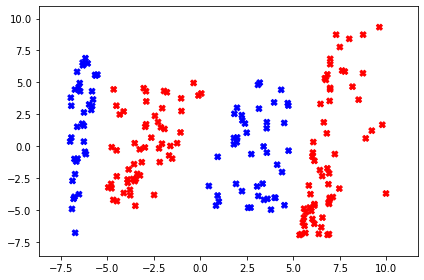

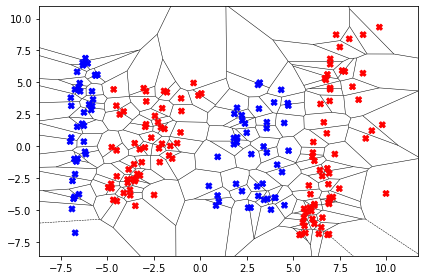

In [299]:
X,Y = load_one_nearest_neighbor_data()
voronoi_plot(X,Y)